In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    with open('training_results.json', 'r') as f:
        results = json.load(f)
    print("Successfully loaded training_results.json")
except FileNotFoundError:
    print("Error: training_results.json not found. Please run main.py first.")
    results = None

Successfully loaded training_results.json


In [2]:
if results:
    # Extract data
    hyperparams = results['hyperparameters']
    stats = results['statistics']
    win_rate_history = results['win_rate_history']

    # Reconstruct Q-table with tuple keys
    q_table = {tuple(map(int, k.strip('()').split(','))): np.array(v)
               for k, v in results['q_table'].items()}

In [3]:
print("\n--- Final Training Statistics ---")
print(f"Total Episodes: {hyperparams['episodes']:,}")
print(f"Total Wins:     {stats['total_wins']:,}")
print(f"Total Losses:   {stats['total_losses']:,}")
print(f"Total Pushes:   {stats['total_pushes']:,}")
print(f"Final Win Rate: {stats['final_win_rate_percent']:.2f}%")


--- Final Training Statistics ---
Total Episodes: 50,000
Total Wins:     20,067
Total Losses:   26,326
Total Pushes:   3,607
Final Win Rate: 40.13%



Generating Win Rate Progression Plot...


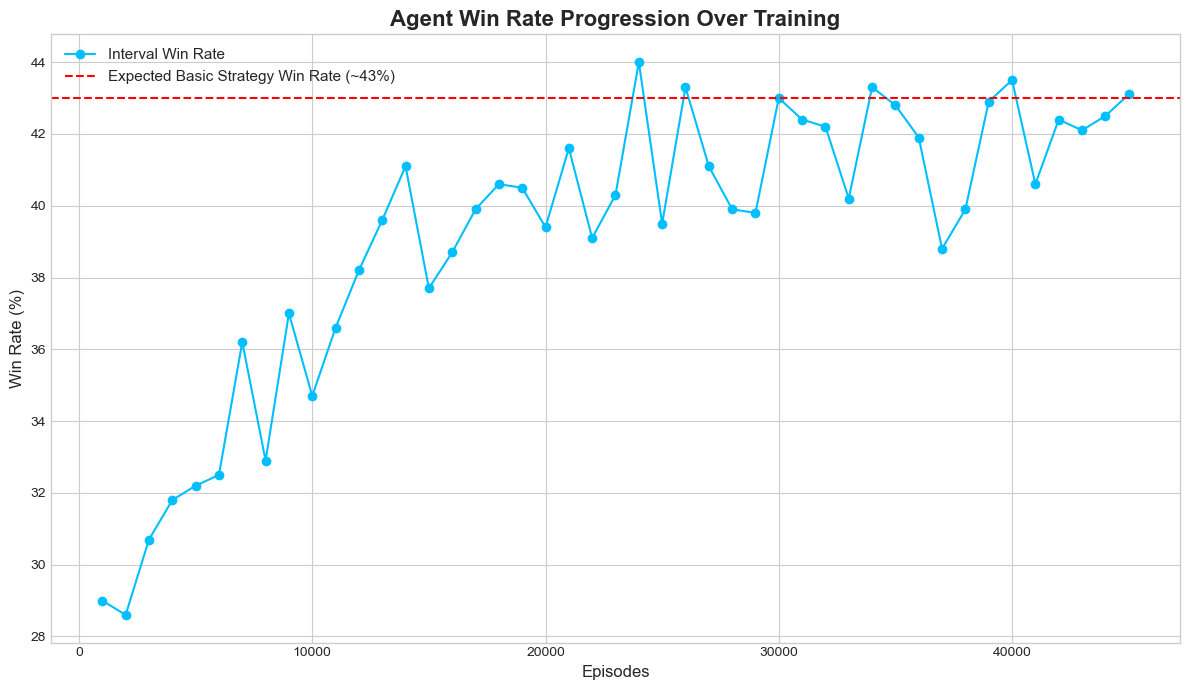

In [9]:
print("\nGenerating Win Rate Progression Plot...")
interval_size = hyperparams['interval_size']
episodes = range(interval_size, (len(win_rate_history) * interval_size) + 1, interval_size)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
plt.plot(episodes, win_rate_history, marker='o', linestyle='-', color='deepskyblue', label='Interval Win Rate')

# Add a line for the expected win rate of basic strategy
plt.axhline(y=43, color='red', linestyle='--', label='Expected Basic Strategy Win Rate (~43%)')

plt.title('Agent Win Rate Progression Over Training', fontsize=16, fontweight='bold')
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Win Rate (%)', fontsize=12)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('plots/win_rate_progression.png', dpi=300)
plt.show()

In [14]:
def create_policy_df(q_table, usable_ace):
    player_sums = sorted(list(set(k[0] for k in q_table.keys() if k[2] == usable_ace)))
    dealer_cards = sorted(list(set(k[1] for k in q_table.keys() if k[2] == usable_ace)))
    
    policy = pd.DataFrame(index=player_sums, columns=dealer_cards)
    
    for player_sum in player_sums:
        for dealer_card in dealer_cards:
            state = (player_sum, dealer_card, usable_ace)
            if state in q_table:
                # Action: 0 for Stand, 1 for Hit
                action = np.argmax(q_table[state])
                policy.loc[player_sum, dealer_card] = action
    return policy.astype(float)

In [15]:
def plot_heatmap(policy_df, title):
    plt.figure(figsize=(12, 9))
    
    # Create the heatmap
    ax = sns.heatmap(policy_df, 
                     cmap=['#d65f5f', '#5fba7d'],
                     annot=True, 
                     fmt=".0f",
                     cbar=False,
                     square=True)
    
    # Customize the plot
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Dealer Upcard Value', fontsize=12, labelpad=10)
    plt.ylabel("Player's Hand Total", fontsize=12, labelpad=10)
    
    # Create a more professional legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor='#d65f5f', label='Stand'),
                      plt.Rectangle((0,0),1,1, facecolor='#5fba7d', label='Hit')]
    
    # Add legend with better positioning and style
    leg = plt.legend(handles=legend_elements,
                    title='Agent Action',
                    title_fontsize=12,
                    fontsize=10,
                    bbox_to_anchor=(1.15, 1),
                    loc='upper left')
    
    # Invert y-axis so higher numbers are at top
    plt.gca().invert_yaxis()
    
    # Add gridlines
    ax.set_axisbelow(True)
    
    # Ensure text annotations are centered
    for t in ax.texts:
        t.set_horizontalalignment('center')
        t.set_verticalalignment('center')
    
    # Adjust layout to prevent cutoff
    plt.tight_layout()
    
    # Create plots directory if it doesn't exist
    import os
    os.makedirs('plots', exist_ok=True)
    
    # Save with high resolution
    filename = f'plots/{title.lower().replace(" ", "_").replace(":", "")}.png'
    plt.savefig(filename, 
                dpi=300, 
                bbox_inches='tight',
                pad_inches=0.5)
    print(f"Saved plot as: {filename}")
    plt.show()

Generating policy heatmaps...

Hard Hands (No Usable Ace):
- Red squares (0) indicate the agent will STAND
- Green squares (1) indicate the agent will HIT
- Rows show player's total, columns show dealer's upcard
Saved plot as: plots/learned_policy_hard_hands.png
Saved plot as: plots/learned_policy_hard_hands.png


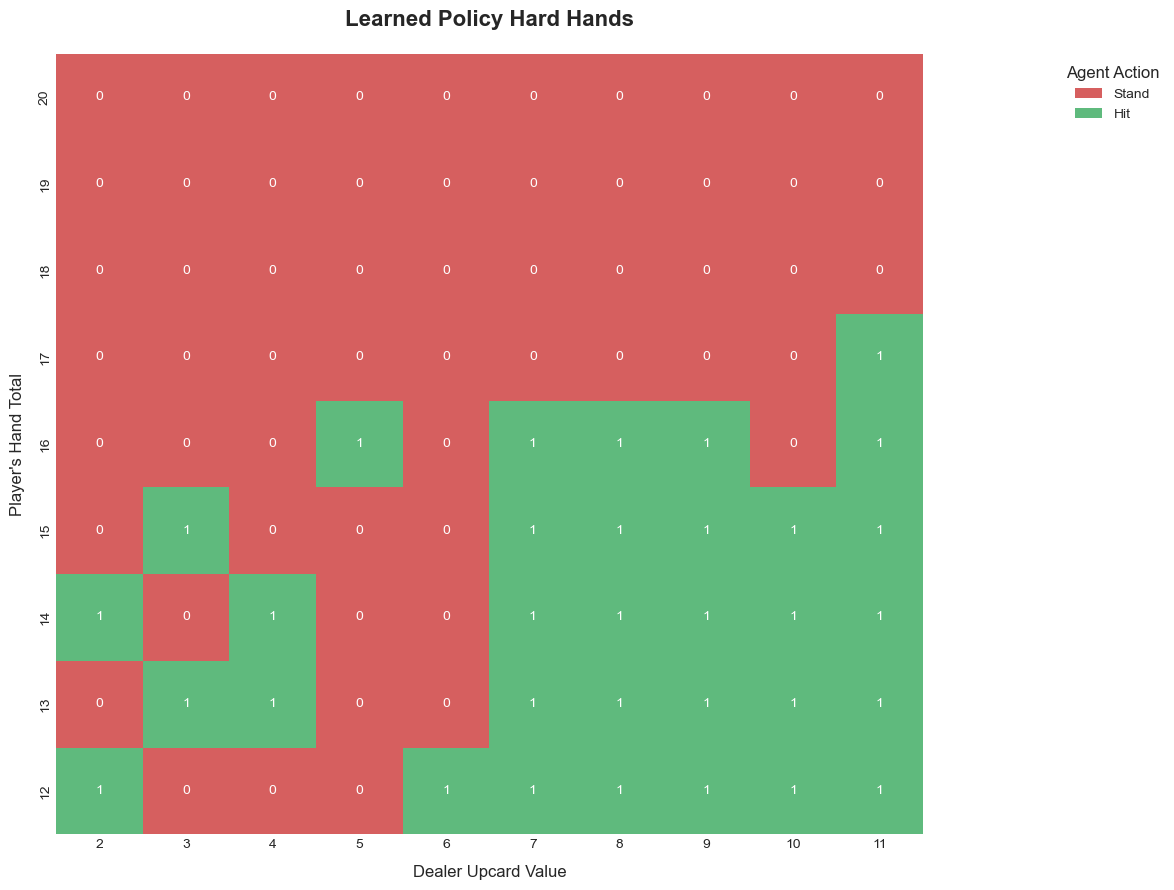

In [16]:
print("Generating policy heatmaps...")
print("\nHard Hands (No Usable Ace):")
print("- Red squares (0) indicate the agent will STAND")
print("- Green squares (1) indicate the agent will HIT")
print("- Rows show player's total, columns show dealer's upcard")

hard_policy = create_policy_df(q_table, usable_ace=0)
plot_heatmap(hard_policy.loc[12:20], 'Learned Policy Hard Hands')


Soft Hands (With Usable Ace):
- These are hands where an Ace can be counted as 11 without busting
- For example, A-6 gives a soft 17 (can become 7 if hit)
- Generally, the agent should be more aggressive with soft hands
Saved plot as: plots/learned_policy_soft_hands.png
Saved plot as: plots/learned_policy_soft_hands.png


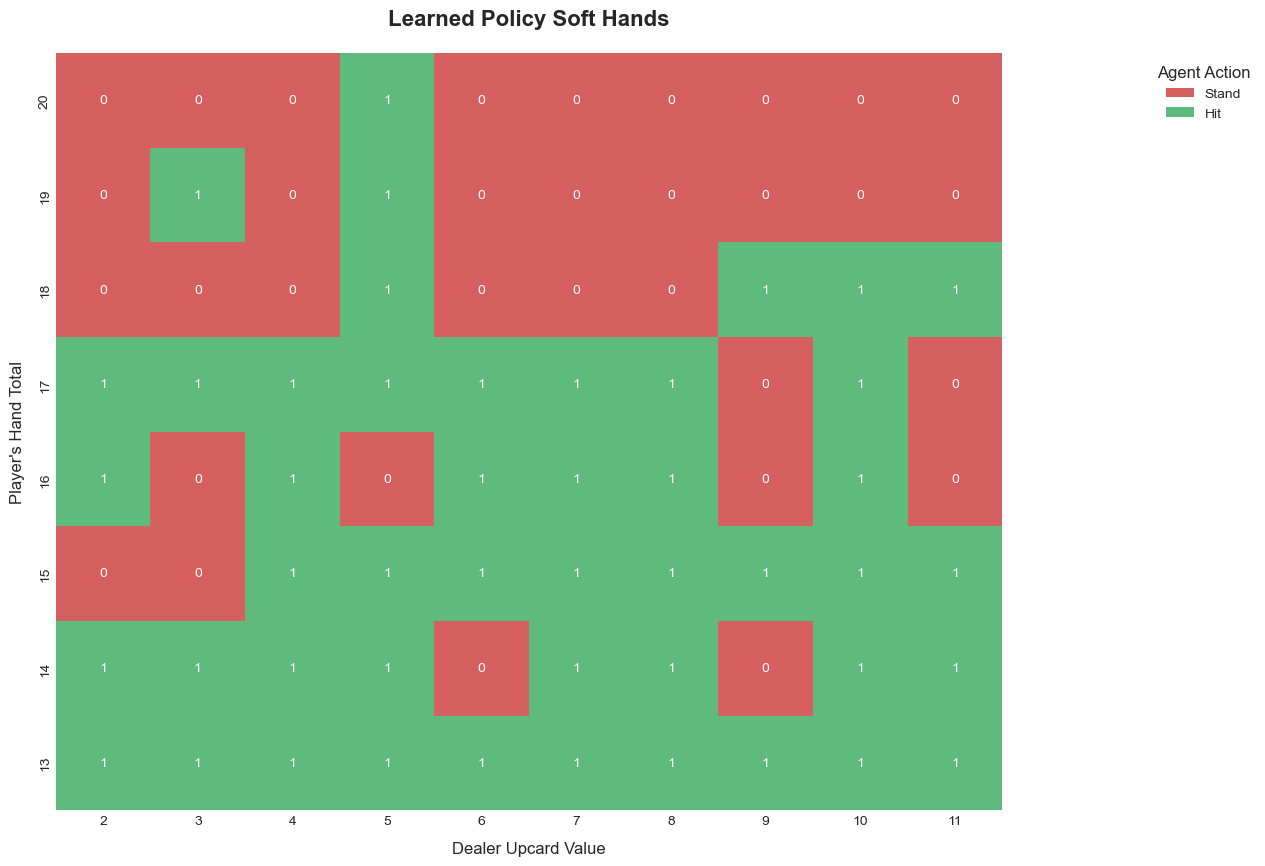

In [17]:
print("\nSoft Hands (With Usable Ace):")
print("- These are hands where an Ace can be counted as 11 without busting")
print("- For example, A-6 gives a soft 17 (can become 7 if hit)")
print("- Generally, the agent should be more aggressive with soft hands")

soft_policy = create_policy_df(q_table, usable_ace=1)
plot_heatmap(soft_policy.loc[13:20], 'Learned Policy Soft Hands')